# Togo Fiber Optics Uptake Prediction Challenge

##### Households and businesses fiber optics access prediction

In [1]:
# Importing the necessary modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
classification_report, confusion_matrix, accuracy_score, 
precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
import seaborn as sns

from pprint import pprint

2024-06-21 14:43:09.026279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 14:43:09.064514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 14:43:09.065163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 14:43:09.892828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading Data

In [2]:
# Train and test dataset reading
df_train = pd.read_csv("datasets/Train.csv")
df_test = pd.read_csv("datasets/Test.csv")

### Exploring and processing the Data

In [3]:
# Shape of train and test datasets
print("Shape of training dataset :", df_train.shape)
print("Shape of testing dataset :", df_test.shape)

Shape of training dataset : (30558, 4043)
Shape of testing dataset : (13097, 4042)


In [4]:
# Counting all the missing values of train and test datasets
print("Number of NA data of training dataset :", df_train.isnull().sum().sum())
print("Number of NA data of testing dataset :", df_test.isnull().sum().sum())

Number of NA data of training dataset : 10508
Number of NA data of testing dataset : 4465


In [5]:
# Making a copy of train and test dataset
df_train_clean = df_train.copy()
df_test_clean = df_test.copy()

In [6]:
# Computing modal values pour every columns
modes_train = df_train_clean.mode().iloc[0]
modes_test = df_test_clean.mode().iloc[0]

In [7]:
# Remplace NaNs by the modal value of every column
df_train_clean = df_train_clean.fillna(modes_train)
df_test_clean = df_test_clean.fillna(modes_test)

In [8]:
df_train_clean['Accès internet'].value_counts()

0    15650
1    14908
Name: Accès internet, dtype: int64

In [9]:
# Checking if missing values exist again in train and test dataset
if df_train_clean.isnull().sum().sum() == 0:
    print("There is no more missing values in train and test dataset :")
    print("Number of NA data of training dataset :", df_train_clean.isnull().sum().sum())
    print("Number of NA data of testing dataset :", df_test_clean.isnull().sum().sum())
else:
    print("Process missing data before continue")

There is no more missing values in train and test dataset :
Number of NA data of training dataset : 0
Number of NA data of testing dataset : 0


In [10]:
# Counting number of duplicated data
if ((df_train_clean.duplicated().sum() == 0) and (df_test_clean.duplicated().sum() == 0)):
    print("There is no duplicated observation in training and testing dataset")
    print("Number of duplicating observatiion of training dataset :", df_train.duplicated().sum())
    print("Number of duplicating observatiion of testing dataset :", df_test.duplicated().sum())
else:
    print("Process duplicated data before continue")

There is no duplicated observation in training and testing dataset
Number of duplicating observatiion of training dataset : 0
Number of duplicating observatiion of testing dataset : 0


In [11]:
pprint(df_train_clean.info())

print("\n----------------------------------------------------------------------------- \n")

pprint(df_test_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30558 entries, 0 to 30557
Columns: 4043 entries, ID to Accès internet
dtypes: float64(4001), int64(1), object(41)
memory usage: 942.6+ MB
None

----------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13097 entries, 0 to 13096
Columns: 4042 entries, ID to  .3999
dtypes: float64(4001), object(41)
memory usage: 403.9+ MB
None


*Train dataset : There are 4 043 columns, 4 002 numerical and 41 categorical variables.*

*Test dataset : There are 4 042 columns, 4 001 numerical and 41 categorical variables.*

In [12]:
df_train_clean.head()

,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,...,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999,Accès internet
0,ID_88M0FMHZAM,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,1.0,Non,Oui,Non,...,0.025202,0.235426,0.251377,0.125899,0.834979,1.055083,0.503122,0.761878,0.018388,0
1,ID_8BRUVGMYT4,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,4.0,Non,Oui,Non,...,0.417944,0.395539,0.243477,0.408191,0.278853,1.134487,0.165434,0.117637,0.214102,1
2,ID_BLWKMPQSDG,Logement moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Charbon de bois,1.0,Non,Non,Non,...,0.059764,0.368242,0.255468,0.195145,0.976152,1.570176,0.669818,0.736460,0.037873,0
3,ID_5FF71INFJ2,Logement moderne,Plusieurs logement,Logement ? un niveau (plain-pied),Electricit? (CEET) compteur dans la concession,Gaz,4.0,Non,Non,Non,...,0.101552,0.474090,0.342558,0.228299,1.054081,1.805052,0.603918,0.746610,0.051638,1
4,ID_BL1YKKNQ4Y,Logement moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Charbon de bois,1.0,Non,Non,Non,...,0.094498,0.410741,0.248533,0.222522,1.012230,1.725041,0.582654,0.770315,0.037564,0


In [13]:
df_test_clean.head()

,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,...,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999
0,ID_6R2X9XE3RA,Logement moderne,Logement unique,Logement ? plusieurs niveaux (? ?tage),Electricit? (CEET) compteur hors concession,Charbon de bois,5.0,Non,Oui,Non,...,0.215417,0.062298,0.328880,0.193603,0.123900,0.773756,1.464494,0.647847,0.448600,0.047404
1,ID_1CQDGXQJW9,Logement moderne,Plusieurs logement,Logement ? un niveau (plain-pied),Electricit? (CEET) compteur dans la concession,Gaz,9.0,Non,Oui,Non,...,0.023053,0.029340,0.204032,0.067190,0.004446,0.034146,0.841245,0.036763,0.003054,0.027603
2,ID_5DQVKM2ODB,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,1.0,Non,Non,Non,...,0.349223,0.096777,0.402451,0.234141,0.230451,1.077133,1.731721,0.600732,0.784672,0.037761
3,ID_65TQFKG2L2,Logement semi-moderne,Logement unique,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Charbon de bois,3.0,Non,Non,Non,...,0.506753,0.151268,0.624592,0.360747,0.351187,1.323039,2.344100,0.900833,0.990587,0.085504
4,ID_NBG4Q4OAF2,Logement semi-moderne,Plusieurs logement,Logement � un niveau (plain-pied),Electricit� (CEET) compteur dans la concession,Gaz,3.0,Non,Non,Oui,...,0.401449,0.127706,0.516138,0.312065,0.277865,1.163575,1.976314,0.677894,0.851412,0.060335


In [14]:
# Rename column name "Accès internet" to "acces_internet"
df_train2 = df_train_clean.rename(columns={'Accès internet': 'Target'})
df_test2 = df_test_clean

In [15]:
numerical_columns = df_train2.select_dtypes(include=[np.number])

print("Numerical columns shape : ", numerical_columns.shape)

for col in numerical_columns.columns:
    print(col)

Numerical columns shape :  (30558, 4002)
TAILLE_MENAGE
 
 .1
 .2
 .3
 .4
 .5
 .6
 .7
 .8
 .9
 .10
 .11
 .12
 .13
 .14
 .15
 .16
 .17
 .18
 .19
 .20
 .21
 .22
 .23
 .24
 .25
 .26
 .27
 .28
 .29
 .30
 .31
 .32
 .33
 .34
 .35
 .36
 .37
 .38
 .39
 .40
 .41
 .42
 .43
 .44
 .45
 .46
 .47
 .48
 .49
 .50
 .51
 .52
 .53
 .54
 .55
 .56
 .57
 .58
 .59
 .60
 .61
 .62
 .63
 .64
 .65
 .66
 .67
 .68
 .69
 .70
 .71
 .72
 .73
 .74
 .75
 .76
 .77
 .78
 .79
 .80
 .81
 .82
 .83
 .84
 .85
 .86
 .87
 .88
 .89
 .90
 .91
 .92
 .93
 .94
 .95
 .96
 .97
 .98
 .99
 .100
 .101
 .102
 .103
 .104
 .105
 .106
 .107
 .108
 .109
 .110
 .111
 .112
 .113
 .114
 .115
 .116
 .117
 .118
 .119
 .120
 .121
 .122
 .123
 .124
 .125
 .126
 .127
 .128
 .129
 .130
 .131
 .132
 .133
 .134
 .135
 .136
 .137
 .138
 .139
 .140
 .141
 .142
 .143
 .144
 .145
 .146
 .147
 .148
 .149
 .150
 .151
 .152
 .153
 .154
 .155
 .156
 .157
 .158
 .159
 .160
 .161
 .162
 .163
 .164
 .165
 .166
 .167
 .168
 .169
 .170
 .171
 .172
 .173
 .174
 .175
 

In [16]:
# Removing dots from column names
df_train2.columns = df_train2.columns.str.replace('.', '')
df_test2.columns = df_test2.columns.str.replace('.', '')

# Checking if dots are removed
numerical_columns = df_train2.select_dtypes(include=[np.number])

for col in numerical_columns.columns:
    print(col)

/tmp/ipykernel_1165119/1422957677.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_train2.columns = df_train2.columns.str.replace('.', '')
/tmp/ipykernel_1165119/1422957677.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_test2.columns = df_test2.columns.str.replace('.', '')


TAILLE_MENAGE
 
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110
 111
 112
 113
 114
 115
 116
 117
 118
 119
 120
 121
 122
 123
 124
 125
 126
 127
 128
 129
 130
 131
 132
 133
 134
 135
 136
 137
 138
 139
 140
 141
 142
 143
 144
 145
 146
 147
 148
 149
 150
 151
 152
 153
 154
 155
 156
 157
 158
 159
 160
 161
 162
 163
 164
 165
 166
 167
 168
 169
 170
 171
 172
 173
 174
 175
 176
 177
 178
 179
 180
 181
 182
 183
 184
 185
 186
 187
 188
 189
 190
 191
 192
 193
 194
 195
 196
 197
 198
 199
 200
 201
 202
 203
 204
 205
 206
 207
 208
 209
 210
 211
 212
 213
 214
 215
 216
 217
 218
 2

In [17]:
# List of categorical column names
categorical_columns = df_train2.select_dtypes(include='O')

print(categorical_columns.shape)

for col in categorical_columns:
    print(col)

(30558, 41)
ID
TypeLogmt_1
TypeLogmt_2
TypeLogmt_3
H08_Impute
H09_Impute
H17A
H17B
H17C
H17D
H17E
H17F
H17G
H17H
H17I
H17J
H17Y
H18A
H18B
H18C
H18D
H18E
H18F
H18G
H18H
H18I
H18J
H18Y
H20A
H20B
H20C
H20D
H20E
H20Y
H21A
H21B
H21C
H21D
H21Y
Connexion
BoxLabel


In [18]:
for col in categorical_columns:
  print(f"Modalités de la variable '{col}':")
  print(df_train2[col].value_counts())
  print("-----------------------------------------------")

Modalités de la variable 'ID':
ID_88M0FMHZAM    1
ID_G0FAF8U5QK    1
ID_I4UGVD8DR9    1
ID_KBP4KNFGXF    1
ID_T9ERP7M70L    1
                ..
ID_7U52B3VEQJ    1
ID_KFUKMGL2R1    1
ID_S444YA1P16    1
ID_78DBS2XGNP    1
ID_QAHVASRC5Z    1
Name: ID, Length: 30558, dtype: int64
-----------------------------------------------
Modalités de la variable 'TypeLogmt_1':
Logement moderne         17892
Logement semi-moderne     9122
Logement traditionnel     3379
Autre                      165
Name: TypeLogmt_1, dtype: int64
-----------------------------------------------
Modalités de la variable 'TypeLogmt_2':
Plusieurs logement    18051
Logement unique       12342
Autre                   165
Name: TypeLogmt_2, dtype: int64
-----------------------------------------------
Modalités de la variable 'TypeLogmt_3':
Logement � un niveau (plain-pied)         19733
Logement ? un niveau (plain-pied)          7237
Logement � plusieurs niveaux (� �tage)     2184
Logement ? plusieurs niveaux (? ?tage)    

#### Rename some value of some categorical variable
Certaines valeurs de certaines variables catégorielles ne sont pas lisibles ni compréhensible. Il est donc nécessaire de les renommer :

    - Pour la colonne 'TypeLogmt_1' : 
        - 'Logement moderne' : 'Moderne'
        - 'Logement semi-moderne' : 'SemiModerne'
        - 'Logement traditionnel' : 'Traditionnel'.
    
    - Pour la colonne 'TypeLogmt_2' :
        - 'Plusieurs logement' : 'Plusieurs'
        - 'Logement unique' : Unique
    
    - Concernant la colonne 'TypeLogmt_3' :
        - 'Logement � un niveau (plain-pied)' : 'UnNiveau'
        - 'Logement ? un niveau (plain-pied)' : 'UnNiveau'
        - 'Logement � plusieurs niveaux (� �tage)' : 'PlusieursNiveaux'
        - 'Logement ? plusieurs niveaux (? ?tage)' : 'PlusieursNiveaux'

    - Pour la variable 'H08_Impute' :
        - 'Electricit� (CEET) compteur dans la concession' : 'CeetCompteurDansLaConcession'
        - 'Electricit? (CEET) compteur dans la concession' : 'CeetCompteurDansLaConcession'
        - 'Electricit? (CEET) compteur hors concession' : 'CeetCompteurHorsConcession'
        - 'Electricit� (CEET) compteur hors concession' : 'CeetCompteurHorsConcession'
        - 'Torche/bougie' :'TorcheOuBougie'
        - 'C?blage d??lectricit? du voisinnage' : 'ElectricitDuVoisinnage'
        - 'C�blage d��lectricit� du voisinnage' : 'ElectricitDuVoisinnage'
        - 'Autre (? pr?ciser)' : 'Autre'
        - 'Autre (� pr�ciser)' : 'Autre'
        - 'Energie solaire' : 'EnergieSolaire'
        - 'Lampe ? p?trole' : 'LampeAPetrole'
        - 'Lampe � p�trole' : 'LampeAPetrole'
        - 'Groupe �lectrog�ne' : 'GroupeElectrogene'
        - 'Groupe ?lectrog?ne' : 'GroupeElectrogene'
        - 'Lampe ? gaz' : 'LampeAGaz'

    - Pour la variable 'H09_Impute' :
        - 'Charbon de bois' : 'CharbonDeBois'
        - 'Bois de chauffe' : 'BoisDeChauffe'
        - '�lectricit�' : 'Electricite'
        - '?lectricit?' : 'Electricite'  
        - 'Ne cuisine pas' : 'NeCuisinePas'  
        - 'P?trole' : 'Petrole'  
        - 'P�trole' : 'Petrole'  
        - 'Autre (? pr?ciser)' : 'Autre'  
        - 'Autre (� pr�ciser' : 'Autre'  
        - 'R�sidus v�g�taux/sciure de bois' : 'ResidusVegetauxOuSciureDeBois'  
        - 'RR?sidus v?g?taux/sciure de boi' : 'ResidusVegetauxOuSciureDeBois'

###### Rename columns values on train and test set

In [19]:
# rename values of TypeLogemt_1 variable
df_train2.loc[df_train2['TypeLogmt_1'] == 'Logement moderne', 'TypeLogmt_1'] = 'Moderne'
df_train2.loc[df_train2['TypeLogmt_1'] == 'Logement semi-moderne', 'TypeLogmt_1'] = 'SemiModerne'
df_train2.loc[df_train2['TypeLogmt_1'] == 'Logement traditionnel', 'TypeLogmt_1'] = 'Traditionnel'

# rename values of TypeLogemt_2 variable
df_train2.loc[df_train2['TypeLogmt_2'] == 'Plusieurs logement', 'TypeLogmt_2'] = 'Plusieurs'
df_train2.loc[df_train2['TypeLogmt_2'] == 'Logement unique', 'TypeLogmt_2'] = 'Unique'

# rename values of TypeLogemt_3 variable
df_train2.loc[df_train2['TypeLogmt_3'] == 'Logement � un niveau (plain-pied)', 'TypeLogmt_3'] = 'UnNiveau'
df_train2.loc[df_train2['TypeLogmt_3'] == 'Logement ? un niveau (plain-pied)', 'TypeLogmt_3'] = 'UnNiveau'
df_train2.loc[df_train2['TypeLogmt_3'] == 'Logement � plusieurs niveaux (� �tage)', 'TypeLogmt_3'] = 'PlusieursNiveaux'
df_train2.loc[df_train2['TypeLogmt_3'] == 'Logement ? plusieurs niveaux (? ?tage)', 'TypeLogmt_3'] = 'PlusieursNiveaux'

# rename values of H08_Impute variable
df_train2.loc[df_train2['H08_Impute'] == 'Electricit� (CEET) compteur dans la concession', 'H08_Impute'] = 'CeetCompteurDansLaConcession'
df_train2.loc[df_train2['H08_Impute'] == 'Electricit? (CEET) compteur dans la concession', 'H08_Impute'] = 'CeetCompteurDansLaConcession'

df_train2.loc[df_train2['H08_Impute'] == 'Electricit? (CEET) compteur hors concession', 'H08_Impute'] = 'CeetCompteurHorsConcession'
df_train2.loc[df_train2['H08_Impute'] == 'Electricit� (CEET) compteur hors concession', 'H08_Impute'] = 'CeetCompteurHorsConcession'

df_train2.loc[df_train2['H08_Impute'] == 'Torche/bougie', 'H08_Impute'] = 'TorcheOuBougie'

df_train2.loc[df_train2['H08_Impute'] == 'C?blage d??lectricit? du voisinnage', 'H08_Impute'] = 'ElectricitDuVoisinnage'
df_train2.loc[df_train2['H08_Impute'] == 'C�blage d��lectricit� du voisinnage', 'H08_Impute'] = 'ElectricitDuVoisinnage'

df_train2.loc[df_train2['H08_Impute'] == 'Autre (? pr?ciser)', 'H08_Impute'] = 'Autre'
df_train2.loc[df_train2['H08_Impute'] == 'Autre (� pr�ciser)', 'H08_Impute'] = 'Autre'

df_train2.loc[df_train2['H08_Impute'] == 'Energie solaire', 'H08_Impute'] = 'EnergieSolaire'
df_train2.loc[df_train2['H08_Impute'] == 'Lampe ? p?trole', 'H08_Impute'] = 'LampeAPetrole'
df_train2.loc[df_train2['H08_Impute'] == 'Lampe � p�trole', 'H08_Impute'] = 'LampeAPetrole'
df_train2.loc[df_train2['H08_Impute'] == 'Groupe �lectrog�ne', 'H08_Impute'] = 'GroupeElectrogene'
df_train2.loc[df_train2['H08_Impute'] == 'Groupe ?lectrog?ne', 'H08_Impute'] = 'GroupeElectrogene'
df_train2.loc[df_train2['H08_Impute'] == 'Lampe ? gaz', 'H08_Impute'] = 'LampeAGaz'

# rename values of H09_Impute variable
df_train2.loc[df_train2['H09_Impute'] == 'Charbon de bois', 'H09_Impute'] = 'CharbonDeBois'
df_train2.loc[df_train2['H09_Impute'] == 'Bois de chauffe', 'H09_Impute'] = 'BoisDeChauffe'
df_train2.loc[df_train2['H09_Impute'] == '�lectricit�', 'H09_Impute'] = 'Electricite'
df_train2.loc[df_train2['H09_Impute'] == '?lectricit?', 'H09_Impute'] = 'Electricite'
df_train2.loc[df_train2['H09_Impute'] == 'Ne cuisine pas', 'H09_Impute'] = 'NeCuisinePas'
df_train2.loc[df_train2['H09_Impute'] == 'P?trole', 'H09_Impute'] = 'Petrole'
df_train2.loc[df_train2['H09_Impute'] == 'P�trole', 'H09_Impute'] = 'Petrole'
df_train2.loc[df_train2['H09_Impute'] == 'Autre (? pr?ciser)', 'H09_Impute'] = 'Autre'
df_train2.loc[df_train2['H09_Impute'] == 'Autre (� pr�ciser)', 'H09_Impute'] = 'Autre'
df_train2.loc[df_train2['H09_Impute'] == 'R�sidus v�g�taux/sciure de bois', 'H09_Impute'] = 'ResidusVegetauxOuSciureDeBois'
df_train2.loc[df_train2['H09_Impute'] == 'R?sidus v?g?taux/sciure de bois', 'H09_Impute'] = 'ResidusVegetauxOuSciureDeBois'
#======================================

In [20]:
# rename values of TypeLogemt_1 variable
df_test2.loc[df_test2['TypeLogmt_1'] == 'Logement moderne', 'TypeLogmt_1'] = 'Moderne'
df_test2.loc[df_test2['TypeLogmt_1'] == 'Logement semi-moderne', 'TypeLogmt_1'] = 'SemiModerne'
df_test2.loc[df_test2['TypeLogmt_1'] == 'Logement traditionnel', 'TypeLogmt_1'] = 'Traditionnel'

# rename values of TypeLogemt_2 variable
df_test2.loc[df_test2['TypeLogmt_2'] == 'Plusieurs logement', 'TypeLogmt_2'] = 'Plusieurs'
df_test2.loc[df_test2['TypeLogmt_2'] == 'Logement unique', 'TypeLogmt_2'] = 'Unique'

# rename values of TypeLogemt_3 variable
df_test2.loc[df_test2['TypeLogmt_3'] == 'Logement � un niveau (plain-pied)', 'TypeLogmt_3'] = 'UnNiveau'
df_test2.loc[df_test2['TypeLogmt_3'] == 'Logement ? un niveau (plain-pied)', 'TypeLogmt_3'] = 'UnNiveau'
df_test2.loc[df_test2['TypeLogmt_3'] == 'Logement � plusieurs niveaux (� �tage)', 'TypeLogmt_3'] = 'PlusieursNiveaux'
df_test2.loc[df_test2['TypeLogmt_3'] == 'Logement ? plusieurs niveaux (? ?tage)', 'TypeLogmt_3'] = 'PlusieursNiveaux'

# rename values of H08_Impute variable
df_test2.loc[df_test2['H08_Impute'] == 'Electricit� (CEET) compteur dans la concession', 'H08_Impute'] = 'CeetCompteurDansLaConcession'
df_test2.loc[df_test2['H08_Impute'] == 'Electricit? (CEET) compteur dans la concession', 'H08_Impute'] = 'CeetCompteurDansLaConcession'

df_test2.loc[df_test2['H08_Impute'] == 'Electricit? (CEET) compteur hors concession', 'H08_Impute'] = 'CeetCompteurHorsConcession'
df_test2.loc[df_test2['H08_Impute'] == 'Electricit� (CEET) compteur hors concession', 'H08_Impute'] = 'CeetCompteurHorsConcession'

df_test2.loc[df_test2['H08_Impute'] == 'Torche/bougie', 'H08_Impute'] = 'TorcheOuBougie'

df_test2.loc[df_test2['H08_Impute'] == 'C?blage d??lectricit? du voisinnage', 'H08_Impute'] = 'ElectricitDuVoisinnage'
df_test2.loc[df_test2['H08_Impute'] == 'C�blage d��lectricit� du voisinnage', 'H08_Impute'] = 'ElectricitDuVoisinnage'

df_test2.loc[df_test2['H08_Impute'] == 'Autre (? pr?ciser)', 'H08_Impute'] = 'Autre'
df_test2.loc[df_test2['H08_Impute'] == 'Autre (� pr�ciser)', 'H08_Impute'] = 'Autre'

df_test2.loc[df_test2['H08_Impute'] == 'Energie solaire', 'H08_Impute'] = 'EnergieSolaire'
df_test2.loc[df_test2['H08_Impute'] == 'Lampe ? p?trole', 'H08_Impute'] = 'LampeAPetrole'
df_test2.loc[df_test2['H08_Impute'] == 'Lampe � p�trole', 'H08_Impute'] = 'LampeAPetrole'
df_test2.loc[df_test2['H08_Impute'] == 'Groupe �lectrog�ne', 'H08_Impute'] = 'GroupeElectrogene'
df_test2.loc[df_test2['H08_Impute'] == 'Groupe ?lectrog?ne', 'H08_Impute'] = 'GroupeElectrogene'
df_test2.loc[df_test2['H08_Impute'] == 'Lampe ? gaz', 'H08_Impute'] = 'LampeAGaz'

# rename values of H09_Impute variable
df_test2.loc[df_test2['H09_Impute'] == 'Charbon de bois', 'H09_Impute'] = 'CharbonDeBois'
df_test2.loc[df_test2['H09_Impute'] == 'Bois de chauffe', 'H09_Impute'] = 'BoisDeChauffe'
df_test2.loc[df_test2['H09_Impute'] == '�lectricit�', 'H09_Impute'] = 'Electricite'
df_test2.loc[df_test2['H09_Impute'] == '?lectricit?', 'H09_Impute'] = 'Electricite'
df_test2.loc[df_test2['H09_Impute'] == 'Ne cuisine pas', 'H09_Impute'] = 'NeCuisinePas'
df_test2.loc[df_test2['H09_Impute'] == 'P?trole', 'H09_Impute'] = 'Petrole'
df_test2.loc[df_test2['H09_Impute'] == 'P�trole', 'H09_Impute'] = 'Petrole'
df_test2.loc[df_test2['H09_Impute'] == 'Autre (? pr?ciser)', 'H09_Impute'] = 'Autre'
df_test2.loc[df_test2['H09_Impute'] == 'Autre (� pr�ciser)', 'H09_Impute'] = 'Autre'
df_test2.loc[df_test2['H09_Impute'] == 'R�sidus v�g�taux/sciure de bois', 'H09_Impute'] = 'ResidusVegetauxOuSciureDeBois'
df_test2.loc[df_test2['H09_Impute'] == 'R?sidus v?g?taux/sciure de bois', 'H09_Impute'] = 'ResidusVegetauxOuSciureDeBois'
#======================================

In [21]:
for col in categorical_columns:
  print(f"Modalités de la variable '{col}':")
  print(df_train2[col].value_counts())
  print("--------------------------------------------")

Modalités de la variable 'ID':
ID_88M0FMHZAM    1
ID_G0FAF8U5QK    1
ID_I4UGVD8DR9    1
ID_KBP4KNFGXF    1
ID_T9ERP7M70L    1
                ..
ID_7U52B3VEQJ    1
ID_KFUKMGL2R1    1
ID_S444YA1P16    1
ID_78DBS2XGNP    1
ID_QAHVASRC5Z    1
Name: ID, Length: 30558, dtype: int64
--------------------------------------------
Modalités de la variable 'TypeLogmt_1':
Moderne         17892
SemiModerne      9122
Traditionnel     3379
Autre             165
Name: TypeLogmt_1, dtype: int64
--------------------------------------------
Modalités de la variable 'TypeLogmt_2':
Plusieurs    18051
Unique       12342
Autre          165
Name: TypeLogmt_2, dtype: int64
--------------------------------------------
Modalités de la variable 'TypeLogmt_3':
UnNiveau            26970
PlusieursNiveaux     3423
Autre                 165
Name: TypeLogmt_3, dtype: int64
--------------------------------------------
Modalités de la variable 'H08_Impute':
CeetCompteurDansLaConcession    24040
CeetCompteurHorsConcession

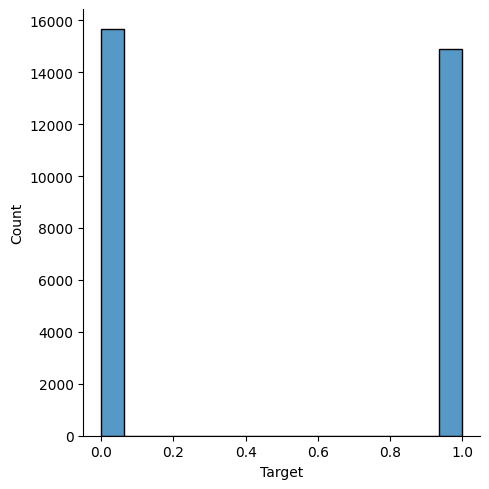

In [22]:
sns.displot(df_train2['Target']);

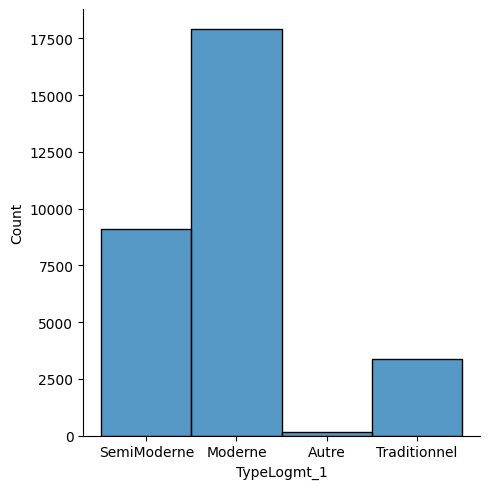

In [23]:
sns.displot(df_train2['TypeLogmt_1']);

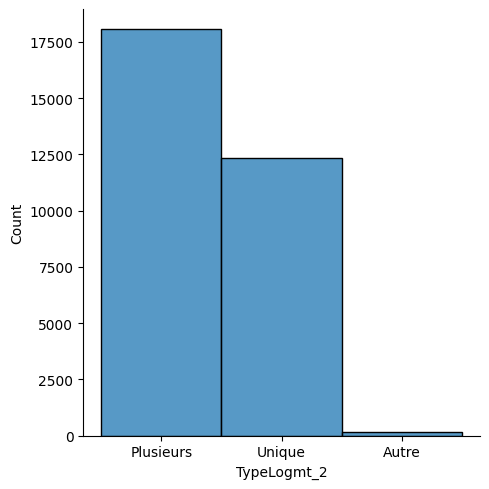

In [24]:
sns.displot(df_train2['TypeLogmt_2']);

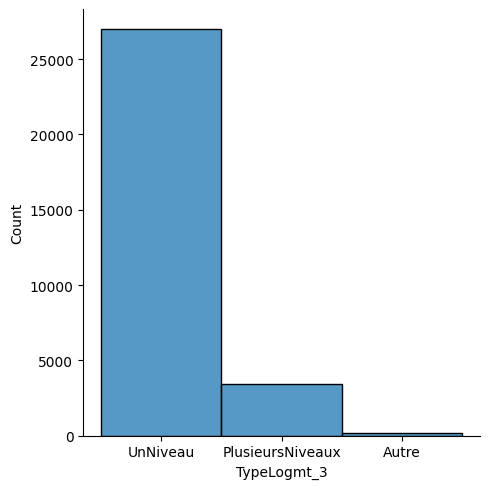

In [25]:
sns.displot(df_train2['TypeLogmt_3']);

In [26]:
categorical_columns = categorical_columns.drop(columns = ['ID'], axis = 1)

In [27]:
# Encoding categorical variables with LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_train2[col] = label_encoder.fit_transform(df_train2[col])
    df_test2[col] = label_encoder.fit_transform(df_test2[col])

In [28]:
df_train2.head()

,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,Target
0,ID_88M0FMHZAM,2,1,2,1,5,1.0,0,1,0,...,0.025202,0.235426,0.251377,0.125899,0.834979,1.055083,0.503122,0.761878,0.018388,0
1,ID_8BRUVGMYT4,2,1,2,1,5,4.0,0,1,0,...,0.417944,0.395539,0.243477,0.408191,0.278853,1.134487,0.165434,0.117637,0.214102,1
2,ID_BLWKMPQSDG,1,1,2,1,3,1.0,0,0,0,...,0.059764,0.368242,0.255468,0.195145,0.976152,1.570176,0.669818,0.736460,0.037873,0
3,ID_5FF71INFJ2,1,1,2,1,5,4.0,0,0,0,...,0.101552,0.474090,0.342558,0.228299,1.054081,1.805052,0.603918,0.746610,0.051638,1
4,ID_BL1YKKNQ4Y,1,1,2,1,3,1.0,0,0,0,...,0.094498,0.410741,0.248533,0.222522,1.012230,1.725041,0.582654,0.770315,0.037564,0


In [29]:
df_test2.head()

,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,ID_6R2X9XE3RA,1,2,1,2,2,5.0,0,1,0,...,0.215417,0.062298,0.328880,0.193603,0.123900,0.773756,1.464494,0.647847,0.448600,0.047404
1,ID_1CQDGXQJW9,1,1,2,1,4,9.0,0,1,0,...,0.023053,0.029340,0.204032,0.067190,0.004446,0.034146,0.841245,0.036763,0.003054,0.027603
2,ID_5DQVKM2ODB,2,1,2,1,4,1.0,0,0,0,...,0.349223,0.096777,0.402451,0.234141,0.230451,1.077133,1.731721,0.600732,0.784672,0.037761
3,ID_65TQFKG2L2,2,2,2,1,2,3.0,0,0,0,...,0.506753,0.151268,0.624592,0.360747,0.351187,1.323039,2.344100,0.900833,0.990587,0.085504
4,ID_NBG4Q4OAF2,2,1,2,1,4,3.0,0,0,1,...,0.401449,0.127706,0.516138,0.312065,0.277865,1.163575,1.976314,0.677894,0.851412,0.060335


##### Building and Training Dense Neural Network model

In [30]:
y = df_train2.iloc[:,-1]
#Y = LabelEncoder().fit_transform(y)
X = df_train2.drop(columns = ['Target'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
id_train = X_train["ID"]
id_test = X_test["ID"]
id_df_test2 = df_test2['ID']

X_train = X_train.drop(columns = ["ID"], axis = 1)
X_test = X_test.drop(columns = ["ID"], axis = 1) 
df_test2 = df_test2.drop(columns = ["ID"], axis = 1)

df_test_val = df_test2.values

# Get the IDs of individuals from the 'ID' column
individual_ids = id_test

In [32]:
# Normalization
# Initialize the StandardScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_test_val = scaler.transform(df_test_val)

/home/anani.djato/Bureau/Documentation/python_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Logistic Regression model

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      3115
           1       0.76      0.84      0.80      2997

    accuracy                           0.79      6112
   macro avg       0.80      0.79      0.79      6112
weighted avg       0.80      0.79      0.79      6112

Confusion Matrix:
[[2332  783]
 [ 479 2518]]
Train Accuracy:  79.41 %
Test Accuracy:  79.35 %
ROC-AUC Score: 84.55 %


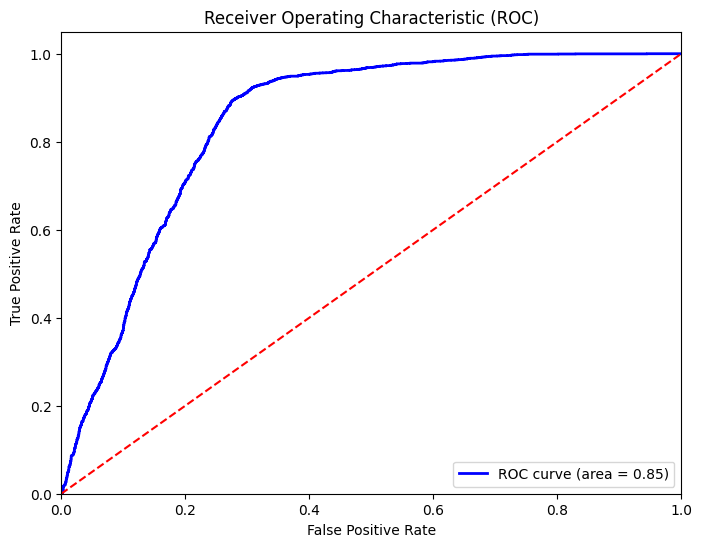

,ID,Target
0,ID_6R2X9XE3RA,1
1,ID_1CQDGXQJW9,1
2,ID_5DQVKM2ODB,1
3,ID_65TQFKG2L2,0
4,ID_NBG4Q4OAF2,0
5,ID_PO9XWZBITP,1
6,ID_NMP70XQMA4,0
7,ID_7V8ZZLHLH1,0
8,ID_B3IY4XIV0W,0
9,ID_U3AZHUXRYY,0


In [33]:
# Define the Logistic Regression with l2 (Ridge) penality
log_model = LogisticRegression(penalty='l2', solver='newton-cg')

# Train the model
log_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train_classes = log_model.predict(X_train)
y_pred_classes = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)[:, 1]
df_test2_pred_classes = log_model.predict(df_test_val)
df_test2_pred_prob = log_model.predict_proba(df_test_val)

# Evaluate the model's performance
print(classification_report(y_test, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Calculate ROC-AUC score
# Calculate test accuracy
train_accuracy = accuracy_score(y_train, y_pred_train_classes)
test_accuracy = accuracy_score(y_test, y_pred_classes)
print("Train Accuracy: ", np.round(train_accuracy, 4)*100, "%")
print("Test Accuracy: ", np.round(test_accuracy, 4)*100, "%")
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", np.round(roc_auc, 4)*100, "%")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Create a DataFrame from predicted classes and IDs
df_results = pd.DataFrame({
    'ID': id_df_test2,
    'Target': df_test2_pred_classes.flatten()
})

# Save the DataFrame to CSV
df_results.to_csv('resultsOfAnaniDJATO.csv', index=False)

# Display the DataFrame
df_results.head(30)

# Interpretation of Logistic Regression Model

In [41]:
result_table = [
    ["Precision",	0.83,	0.76,	0.80],
    ["Recall",	0.76,	0.84,	0.80],
    ["F1-score",	0.79,	0.80,	0.80]
]

col = ["Metric",	"Class 0",	"Class 1",	"Overall Average"]

# Create a DataFrame from the
df_results = pd.DataFrame(result_table, columns=col)

# Display the DataFrame
df_results

,Metric,Class 0,Class 1,Overall Average
0,Precision,0.83,0.76,0.8
1,Recall,0.76,0.84,0.8
2,F1-score,0.79,0.80,0.8


In [40]:
print("""
The results indicate that Dense Neural Network model has a good overall performance with a 
balanced precision and recall. The test and train accuracies are similar (79.35% and 79.41% respectively), 
indicating that the model is not overfitting and has good generalization capabilities. The high ROC-AUC score 
(84.55%) and the shape of the ROC curve suggest that the model effectively discriminates between the classes.
""")


The results indicate that Dense Neural Network model has a good overall performance with a 
balanced precision and recall. The test and train accuracies are similar (79.35% and 79.41% respectively), 
indicating that the model is not overfitting and has good generalization capabilities. The high ROC-AUC score 
(84.55%) and the shape of the ROC curve suggest that the model effectively discriminates between the classes.



### Details

**79% of all predictions were correct.**

#### Area Under the Receiver Operating Characteristic Curve (ROC AUC) :
A score of **84.55%** indicates good ability to distinguish between the two classes.


For **class 0**, the precision is **0.83**, meaning **83%** of the class **'no Internet access'** predictions are correct.   
For **class 1**, the precision is **0.76**. So **76%** of class **'is Internet access'** predictions are correct.   

**Train accuracy = 79.41%**

**Test accuracy = 79.35%**
So, the model fits the training data well without significant overfitting.
Test accuracy is very close to the training accuracy, indicating good generalization ability of the model.


The ROC-AUC score is **84.55%**, which is a good indication of the model’s 
overall ability to distinguish between the positive and negative classes

## Dense Neural Network model

Epoch 1/300
392/392 [==============================] - 2s 5ms/step - loss: 0.6878 - accuracy: 0.5573 - val_loss: 0.6587 - val_accuracy: 0.6814
Epoch 2/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6643 - accuracy: 0.6187 - val_loss: 0.6305 - val_accuracy: 0.7002
Epoch 3/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6548 - accuracy: 0.6302 - val_loss: 0.6125 - val_accuracy: 0.7174
Epoch 4/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6519 - accuracy: 0.6392 - val_loss: 0.6172 - val_accuracy: 0.7184
Epoch 5/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6481 - accuracy: 0.6449 - val_loss: 0.6055 - val_accuracy: 0.7317
Epoch 6/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6434 - accuracy: 0.6556 - val_loss: 0.6042 - val_accuracy: 0.7372
Epoch 7/300
392/392 [==============================] - 2s 4ms/step - loss: 0.6376 - accuracy: 0.6651 - val_loss: 0.5932 - val_accuracy: 0.7421

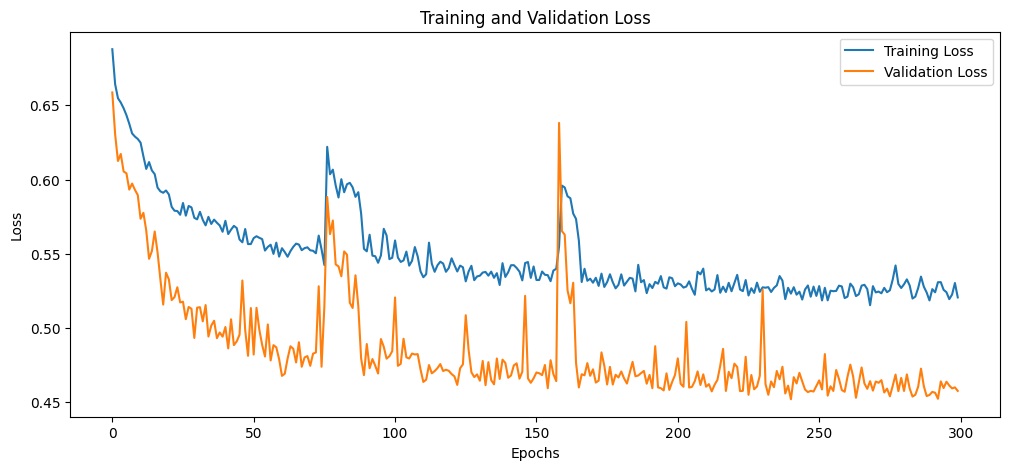

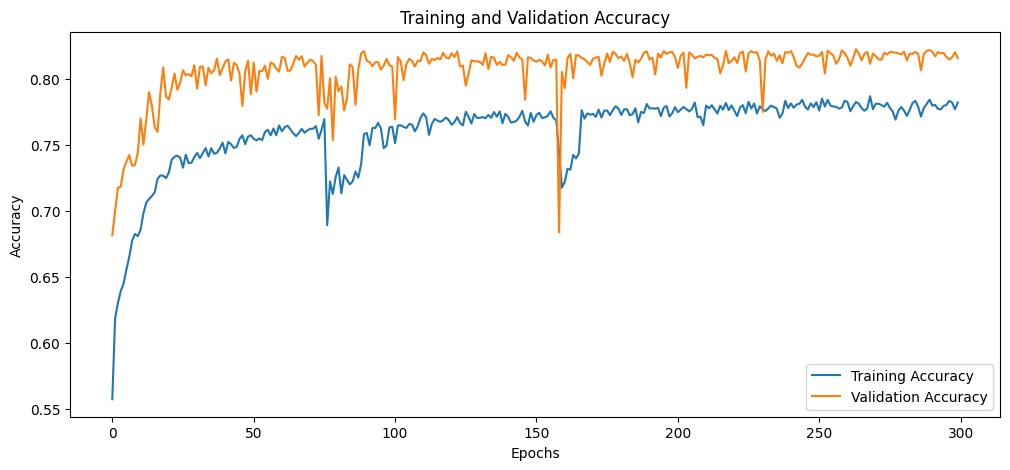

103/764 [===>..........................] - ETA: 0s

2024-06-21 15:44:53.671577: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 395145144 exceeds 10% of free system memory.


410/410 [==============================] - 0s 949us/step
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      3115
           1       0.75      0.93      0.83      2997

    accuracy                           0.81      6112
   macro avg       0.83      0.82      0.81      6112
weighted avg       0.83      0.81      0.81      6112

Confusion Matrix:
[[2177  938]
 [ 205 2792]]
Train Accuracy:  80.91000000000001 %
Test Accuracy:  81.3 %
ROC-AUC Score: 83.03 %


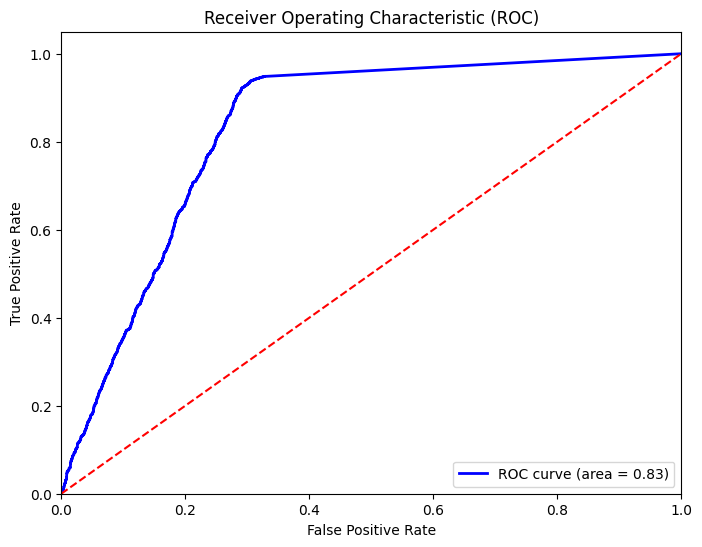

,ID,Target
0,ID_6R2X9XE3RA,1
1,ID_1CQDGXQJW9,1
2,ID_5DQVKM2ODB,1
3,ID_65TQFKG2L2,0
4,ID_NBG4Q4OAF2,0
5,ID_PO9XWZBITP,1
6,ID_NMP70XQMA4,0
7,ID_7V8ZZLHLH1,0
8,ID_B3IY4XIV0W,0
9,ID_U3AZHUXRYY,0


In [36]:
# Define the model
model = Sequential()
model.add(Dense(128, input_dim=4041, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model and capture the training history
history = model.fit(X_train, y_train, epochs=300, batch_size=50, validation_split=0.2, verbose=1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

# Predictions
y_pred_train_prob = model.predict(X_train).flatten()
y_pred_train_classes = (y_pred_train_prob >= 0.5).astype(int)

y_pred_prob = model.predict(X_test).flatten()
y_pred_classes = (y_pred_prob >= 0.5).astype(int)

df_test2_pred_prob = model.predict(df_test_val).flatten()
df_test2_pred_classes = (df_test2_pred_prob >= 0.5).astype(int)

# Model evaluation
print(classification_report(y_test, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

train_accuracy = accuracy_score(y_train, y_pred_train_classes)
test_accuracy = accuracy_score(y_test, y_pred_classes)
print("Train Accuracy: ", np.round(train_accuracy, 4) * 100, "%")
print("Test Accuracy: ", np.round(test_accuracy, 4) * 100, "%")

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", np.round(roc_auc, 4) * 100, "%")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save the results
df_results = pd.DataFrame({
    'ID': id_df_test2,
    'Target': df_test2_pred_classes.flatten()
})
df_results.to_csv('resultsOfAnaniDJATO.csv', index=False)
df_results.head(30)

# Interpretation of Dense Neural Network Model

In [37]:
result_table = [
    ["Precision",	0.91,	0.75,	0.83],
    ["Recall",	0.70,	0.93,	0.82],
    ["F1-score",	0.79,	0.83,	0.81]
]

col = ["Metric",	"Class 0",	"Class 1",	"Overall Average"]

# Create a DataFrame from the
df_results = pd.DataFrame(result_table, columns=col)

# Display the DataFrame
df_results

,Metric,Class 0,Class 1,Overall Average
0,Precision,0.91,0.75,0.83
1,Recall,0.70,0.93,0.82
2,F1-score,0.79,0.83,0.81


In [38]:
print("""
The results indicate that Dense Neural Network model has a good overall performance with a 
balanced precision and recall. The test and train accuracies are similar (81.30% and 80.91% respectively), 
indicating that the model is not overfitting and has good generalization capabilities. The high ROC-AUC score 
(83.03%) and the shape of the ROC curve suggest that the model effectively discriminates between the classes.
""")


The results indicate that Dense Neural Network model has a good overall performance with a 
balanced precision and recall. The test and train accuracies are similar (81.30% and 80.91% respectively), 
indicating that the model is not overfitting and has good generalization capabilities. The high ROC-AUC score 
(83.03%) and the shape of the ROC curve suggest that the model effectively discriminates between the classes.



### Details

**81% of all predictions were correct.**

#### Area Under the Receiver Operating Characteristic Curve (ROC AUC) :
A score of **83.03%** indicates good ability to distinguish between the two classes.


For **class 0**, the precision is **0.91**, meaning **91%** of the class **'no Internet access'** predictions are correct.   
For **class 1**, the precision is **0.75**. So **75%** of class **'is Internet access'** predictions are correct.   

**Train accuracy = 80.91%**

**Test accuracy = 81.30%**
So, the model fits the training data well without significant overfitting.
Test accuracy is very close to the training accuracy, indicating good generalization ability of the model.


The ROC-AUC score is **83.03%**, which is a good indication of the model’s 
overall ability to distinguish between the positive and negative classes

# Comparaison of Logistic Regression and Dense Neural Network models

En termes de taux de généralisation, le modèle de Réseau de neurones denses est legèrement mieux que le modèle de Regression Logistique.
En effet, il y a un taux de précision de 81% pour le modèle de réseau de neurones dense et de 79% pour le modèle de regression logistique.

Cependant, si on regarde l'Aire sous la courbe ROC (ROC AUC), le modèle de regression logistique est légèrement plus performant que le modèle de réseaux de neurones dense : **84.55%** contre **83.03%**.

#### Pourquoi pour le moi le modèle de réseau de neurones est mieux ?
- D'abord, il n'y a pas trop de différence entre les métriques
- En plus, lorsque le volume des données sur lesquelles on a entrainé les 2 modèles va augementer, le modèle de réseau de neurones denses va pouvoir apprendre de lui même et améliorer tout seul ses performances.

# Comparison of Logistic Regression and Dense Neural Network Models

In terms of generalization rate, the Dense Neural Network model is slightly better than the Logistic Regression model. 
In fact, the Dense Neural Network model has an accuracy rate of **81%**, while the Logistic Regression model has an accuracy rate of **79%**.

However, if we look at the **Area Under the ROC Curve (ROC AUC)**, the Logistic Regression model slightly outperforms the Dense Neural Network model: **84.55%** versus **83.03%**.

### Why do I think the neural network model is better?
    - First, there is not a big difference between the metrics of the 2 models. 
    
    - In addition, when the volume of data on which the 2 models have been trained increases, 
    the dense neural network model will be able to learn on its own and improve its performance on its own.